# Project: Colorectal Polyp Segmentation on Kvasir-SEG Dataset

In this project, which is intended as a final project for Artificial Intelligence course in University of Tehran, department of computer science, we will use machine learning for segmentation of colorectal polyps images obtained from Kvasir-SEG dataset, an open-source dataset made available for study of computer vision methods in medical imaging processing field.

Colorectal polyps are precursors to colorectal cancer, which is why detection of such polyps and possibly their removal can help reduce cancer risk. Early detection can be life saving and detection of this polyp has a high miss-rate. This is why advancing machine learning methods in helping professionals in detection of these polyps is highly important.

### 1. Importing Necessary Packages and Loading the Dataset
First, we import all the necessary modules, libraries and files. This includes TensorFlow for building neural networks, NumPy for linear algebra and Kvasir-SEG dataset which contains annotated images of polyps in the gastrointenstinal tract and segmentation masks for them.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Download the Kvasir-Seg dataset
!wget https://datasets.simula.no/downloads/kvasir-seg.zip -O kvasir-seg.zip
!unzip -q kvasir-seg.zip -d Kvasir-SEG
!rm kvasir-seg.zip

path = ''
image_path = os.path.join(path, './Kvasir-SEG/Kvasir-SEG/images/')
mask_path = os.path.join(path, './Kvasir-SEG/Kvasir-SEG/masks/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

--2025-02-01 13:53:36--  https://datasets.simula.no/downloads/kvasir-seg.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46227172 (44M) [application/zip]
Saving to: ‘kvasir-seg.zip’

kvasir-seg.zip      100%[===================>]  44.08M  13.4MB/s    in 3.3s    

2025-02-01 13:53:40 (13.4 MB/s) - ‘kvasir-seg.zip’ saved [46227172/46227172]



### 2. Familiarizing with Kvasir-SEG Dataset

Checking out some of the images and checking for information like the size of the dataset.

In [3]:
len(image_list)

1000

With each run of the following code block a random image and its corresponding segmentation mask are displayed side by side to get a feel for the dataset.

<ipython-input-4-55c5b5a33067>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-4-55c5b5a33067>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

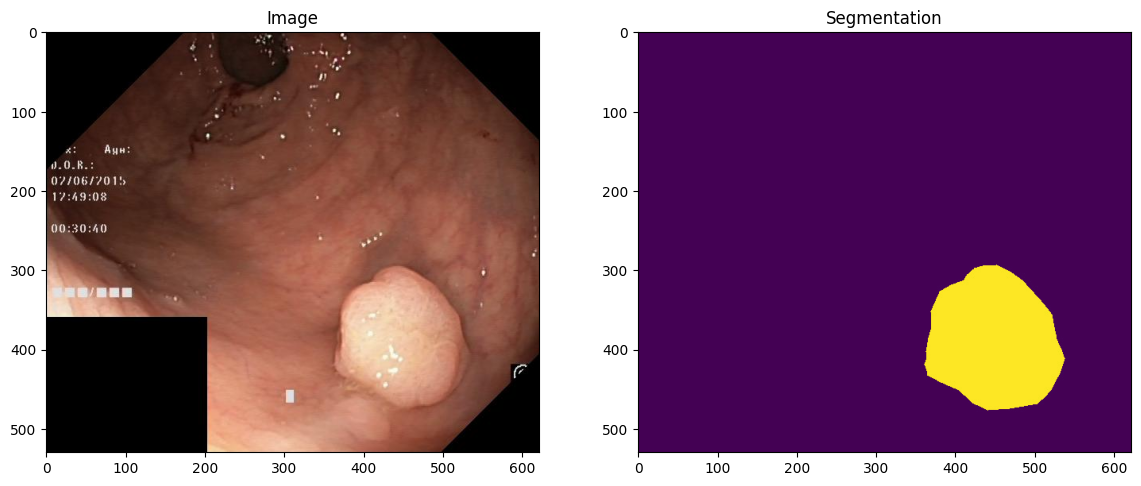

In [4]:
N = np.random.randint(0, 1000)
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### 3. Preprocess the Data (Train/Test Split, Normalizing, Resizing, ...)

In [5]:
# Split into train and test sets (80% train, 20% test)
train_images, test_images, train_masks, test_masks = train_test_split(
    image_list, mask_list, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

In preprocessing of the images they are decoded, converted, resized and normalized:

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255
    input_mask = input_mask / 255

    # Ensure mask is binary after resizing
    input_mask = tf.where(input_mask > 0.5, 1, 0)

    return input_image, input_mask

In [7]:
BUFFER_SIZE = 500
BATCH_SIZE = 16

# Process and batch the training dataset
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Process and batch the test dataset
test_dataset = test_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 4. U-Net
U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. The U-Net is a type of convolutional neural network in which the initial covolution and pooling stages lead to transpose convolution layers that that upsamples the feature map back to the size of the original input image which was reduced due to convolution and pooling. This model is widely used for medical image segmentation, which is why we will use it here for segmentation of colorectal polyps.

This model consists an encoder and a decoder section. The encoder section is made up of repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling.

In the decoder section, expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU.

In its final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes (two in our case).

One important aspcet of U-Nets are the residual neural network-like skip connections from the earlier encoder layers to the later decoding ones.

In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """ Implement a convolution block that downsampling """

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)

    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer, with dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [9]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """ Implement convolutional upsampling block """
    """
    expansive_input, is the previous layer given as input
    contractive_input, is the skip connection layer given as input
    """
    up = Conv2DTranspose(
                 n_filters,
                 3,
                 strides=2,
                 padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)

    return conv

In [10]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """ The full U-net model implemented """

    inputs = Input(input_size)

    # Contracting Path (encoding)
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)

    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)

    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)

    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)

    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)

    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)

    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)

    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [11]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [12]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 128, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 96, 128, 32)    │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 96, 128, 32)    │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 48, 64, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 48, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 48, 64, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 24, 32, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 24, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 24, 32, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 12, 16, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 12, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 12, 16, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 12, 16, 256)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 8, 256)      │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 6, 8, 512)      │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 6, 8, 512)      │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 6, 8, 512)      │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 8,639,745 (32.96 MB)

 Trainable params: 8,639,745 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
unet.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.MeanIoU(num_classes=2), 'accuracy'])

In [14]:

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

## 5. Training

In [15]:
# Check if GPU is available
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
EPOCHS = 80
model_history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)

Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 329ms/step - accuracy: 0.7809 - loss: 0.7209 - mean_io_u: 0.4221 - val_accuracy: 0.8422 - val_loss: 0.4441 - val_mean_io_u: 0.4211
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.8457 - loss: 0.4342 - mean_io_u: 0.4229 - val_accuracy: 0.8422 - val_loss: 0.3895 - val_mean_io_u: 0.4211
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8479 - loss: 0.3806 - mean_io_u: 0.4239 - val_accuracy: 0.8422 - val_loss: 0.3633 - val_mean_io_u: 0.4211
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8468 - loss: 0.3715 - mean_io_u: 0.4234 - val_accuracy: 0.8422 - val_loss: 0.3509 - val_mean_io_u: 0.4211
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8463 - loss: 0.3438 - mean_io_u: 0.4231 - val_accuracy: 0.8460 - val_loss: 0.3398 - val_mean_io_u: 0.4211
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8537 - loss: 0.3331 - mean_io_u: 0.4252 - val_accuracy: 0.8487 - val_loss:

In [17]:
def create_mask(pred_mask, threshold=0.5):
    pred_mask = pred_mask > threshold  # Apply threshold
    return pred_mask[0]

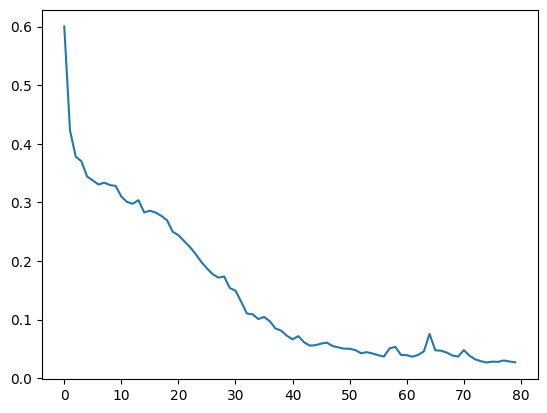

In [18]:
plt.plot(model_history.history["loss"])

In [19]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [20]:
# Evaluate the model on the test dataset
test_loss, test_meanIoU, test_accuracy = unet.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MeanIoU: {test_meanIoU}")
print(f"Test Accuracy: {test_accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8979 - loss: 0.7288 - mean_io_u: 0.4180
Test Loss: 0.5540451407432556
Test MeanIoU: 0.42739126086235046
Test Accuracy: 0.9182775616645813


Let us observe some of the training predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


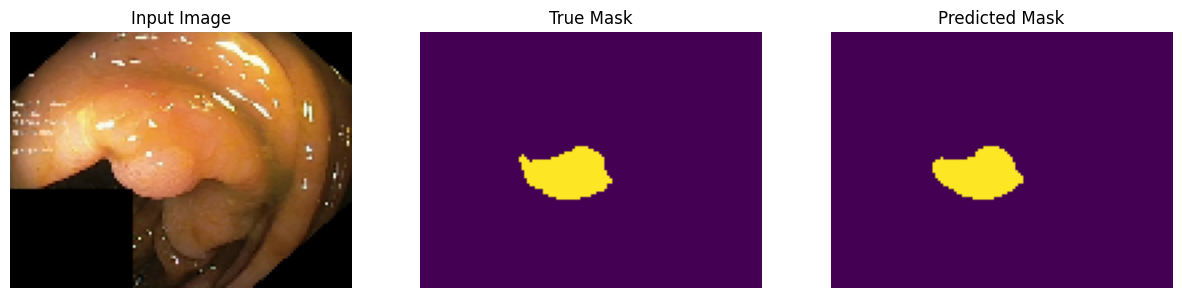

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


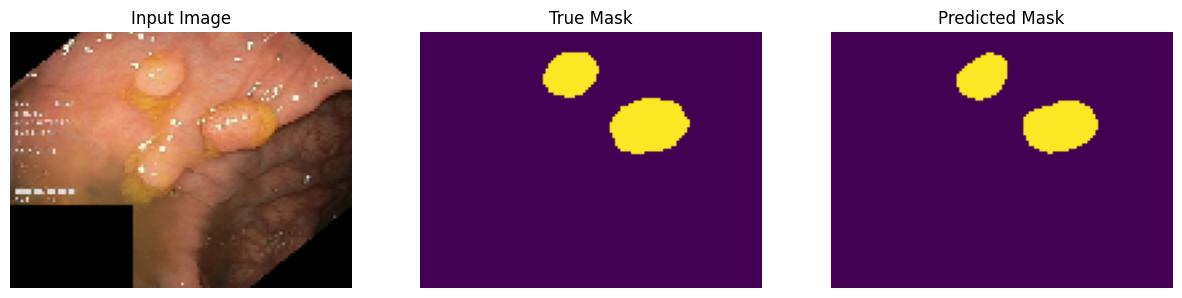

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


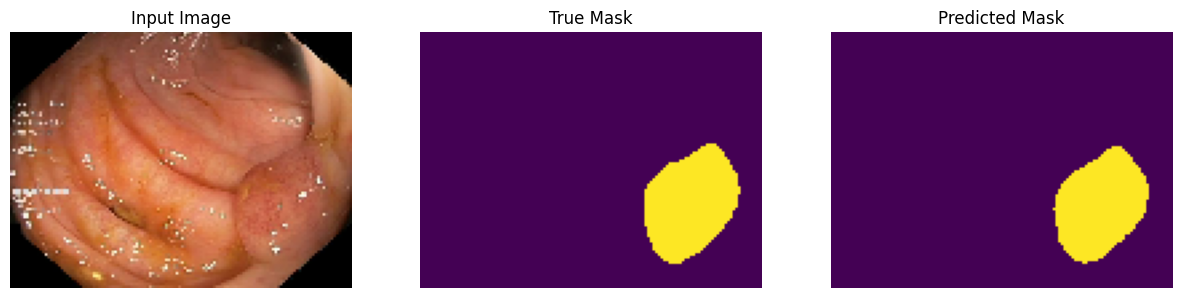

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


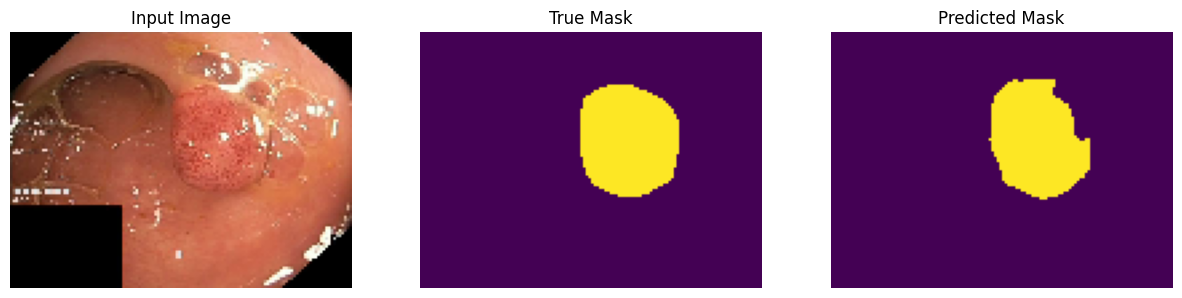

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


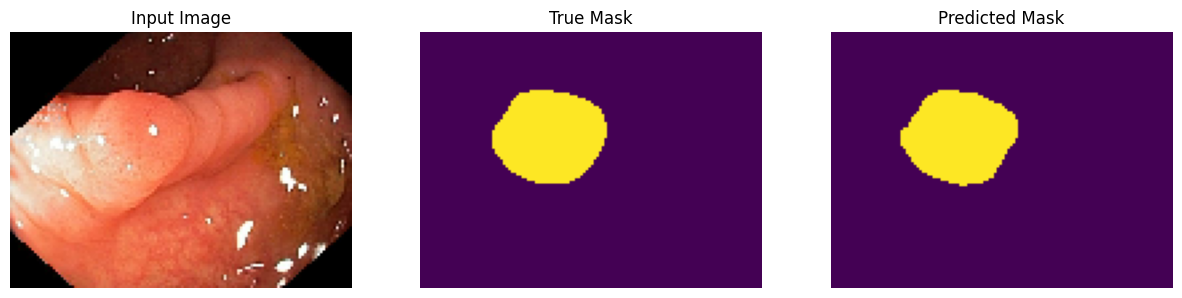

In [22]:
show_predictions(train_dataset, 5)

Let us observe some of the test predicitons.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


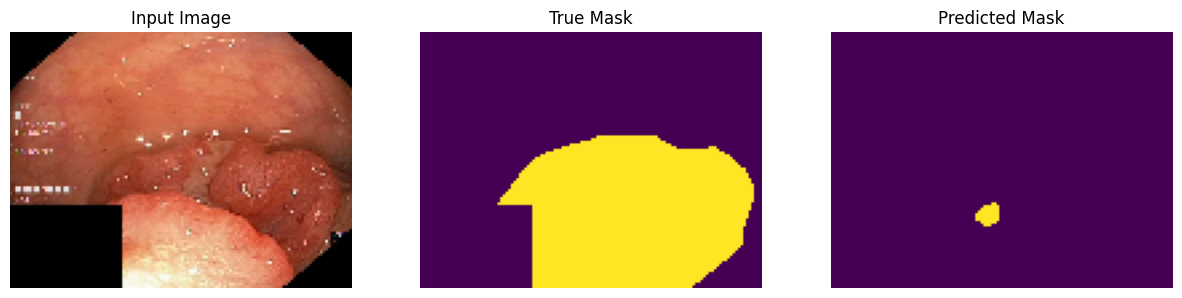

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


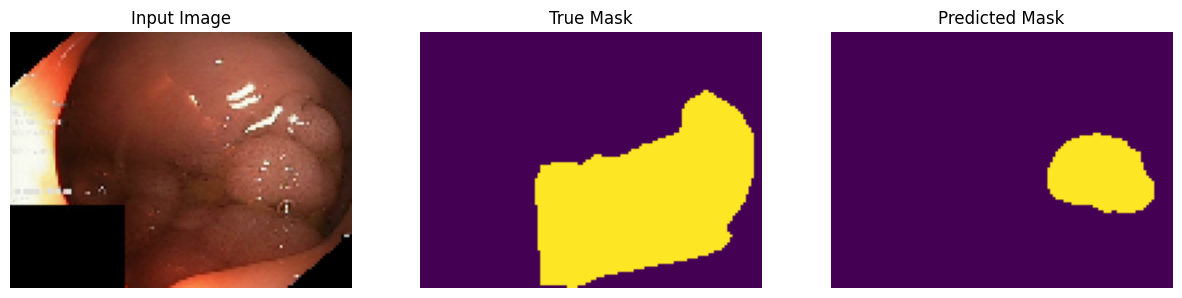

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


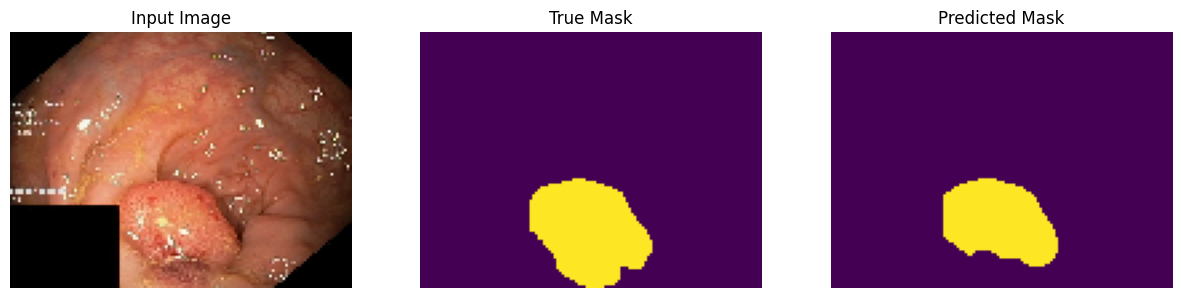

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


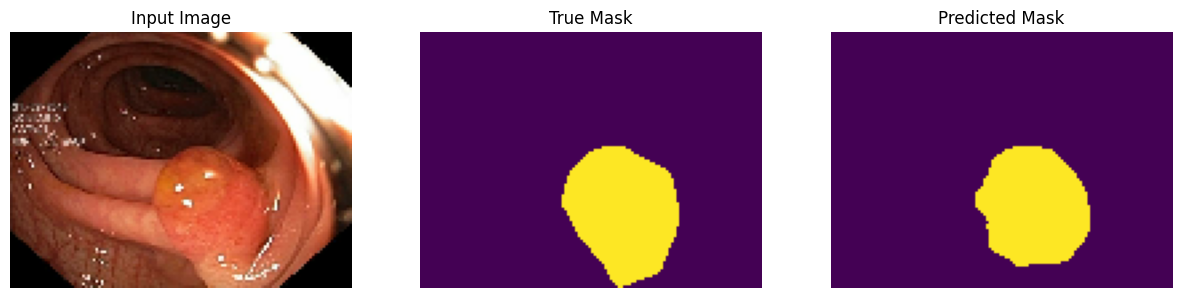

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


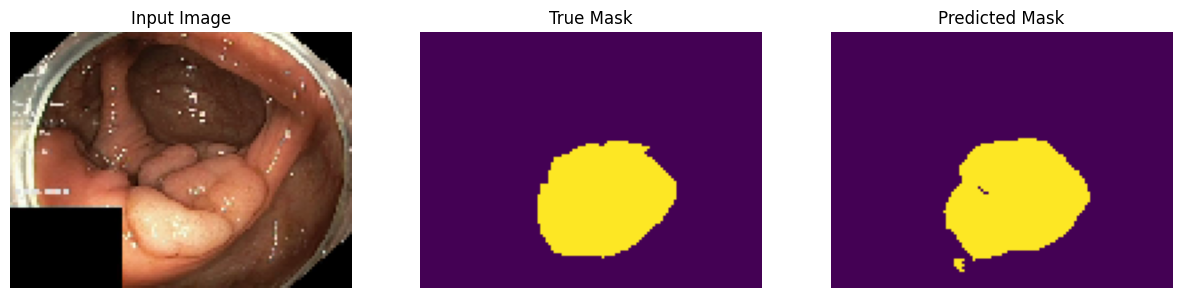

In [21]:
show_predictions(test_dataset, 5)